# Predict a building's Energy Star 
### Part 1 - EDA

## Imports

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# Data Cleaning and Formatting

## Load in the Data and Examine

In [2]:
# Read in data into a dataframe 
data = pd.read_csv('data/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')

# Display top of dataframe
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,891040.0,Hos

**Target `score`**: the Energy Star Score is a method of ranking buildings in terms of energy efficiency with 1 the worst and 100 the best. It is a relative percentile ranking which means buildings are scored relative to one another and should display a uniform distribution across the range of values.

## Data Types and Missing Values

Missing values are coded as "Not Available" rather than as `np.nan` (not a number).

In [3]:
# See the column data types and non-missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
Order                                                         11746 non-null int64
Property Id                                                   11746 non-null int64
Property Name                                                 11746 non-null object
Parent Property Id                                            11746 non-null object
Parent Property Name                                          11746 non-null object
BBL - 10 digits                                               11735 non-null object
NYC Borough, Block and Lot (BBL) self-reported                11746 non-null object
NYC Building Identification Number (BIN)                      11746 non-null object
Address 1 (self-reported)                                     11746 non-null object
Address 2                                                     11746 non-null object
Postal Code                                          

### Convert Data to Correct Types

In [4]:
# Replace all occurrences of Not Available with numpy not a number
data = data.replace({'Not Available': np.nan})

# Iterate through the columns
for col in list(data.columns):
    # Select columns that should be numeric
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        # Convert the data type to float
        data[col] = data[col].astype(float)

## Missing Values

In [5]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
missing_values_table(data)

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.


,Missing Values,% of Total Values
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
3rd Largest Property Use Type,10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0
2nd Largest Property Use Type,8005,68.2


In [7]:
# Get the columns with > 50% missing
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.
We will remove 11 columns.


In [8]:
# Drop the columns
data = data.drop(columns = list(missing_columns))

The rest of the missing values will have to be imputed (filled-in) using an appropriate strategy before doing machine learning. 

# Exploratory Data Analysis

## Single Variable Plots

A single variable (called [univariate](https://en.wikipedia.org/wiki/Univariate_(statistics)) plot shows the distribution of a single variable such as in a histogram.

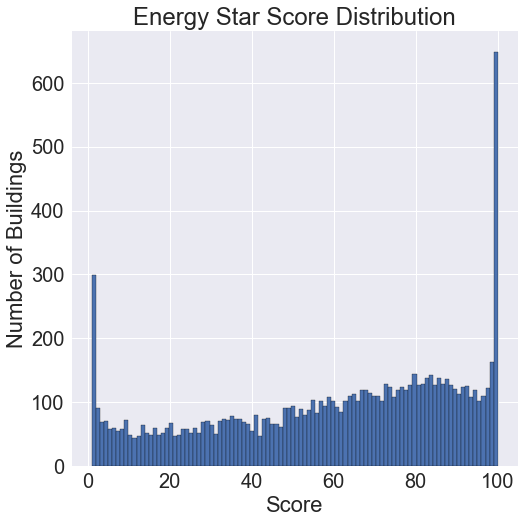

In [9]:
figsize(8, 8)

# Rename the score 
data = data.rename(columns = {'ENERGY STAR Score': 'score'})

# Histogram of the Energy Star Score
plt.hist(data['score'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Score'); plt.ylabel('Number of Buildings'); 
plt.title('Energy Star Score Distribution');

Our first plot has already revealed some surprising (and suspicious) information! As the Energy Star Score is a percentile rank, we would expect to see a completely flat distribution with each score making up 1% of the distribution (about 90 buildings). However, this is definitely not the case as we can see that the two most common scores, 1 and 100, make up a disproporationate number of the overall scores. 

If we go back to the definition of the score, we see it is based on self-reported energy usage. This poses a problem, because a building owner might be tempted to report lower electricity usage to artificially boost the score of their building. It is like giving students a grade based on self-reported test scores. This behavior would explain the high percentage of buildings with a perfect score of 100, but does not explain why so many buildings score at the very bottom! 

To contrast the Energy Star Score, we can look at the Energy Use Intensity (EUI), which is the total energy use divided by the square footage of the building. Here the energy usage is not self-reported, so this could be a more objective measure of the energy efficiency of a building. Moreover, this is not a percentile rank, so the absolute values are important and we would expect them to be approximately normally distributed with perhaps a few outliers on the low or high end. 

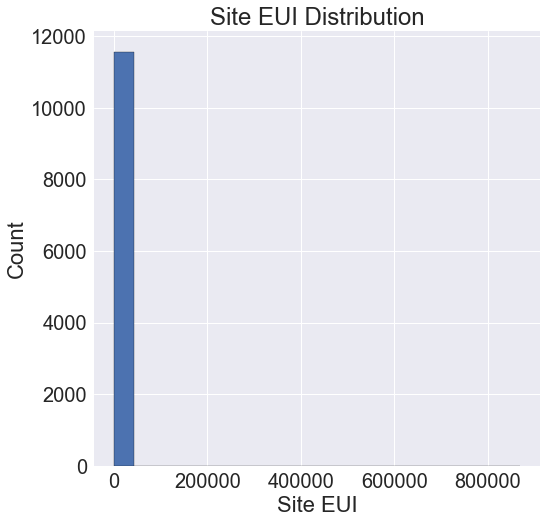

In [10]:
# Histogram Plot of Site EUI
figsize(8, 8)
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); plt.title('Site EUI Distribution');

Well this shows us we have another problem: outliers! The graph is incredibly skewed because of the presence of a few buildings with very high scores. It looks like we will have to take a slight detour to deal with the outliers. Let's look at the stats for this feature.

In [11]:
data['Site EUI (kBtu/ft²)'].describe()

count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

In [12]:
data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(10)

3173     51328.8
3170     51831.2
3383     78360.1
8269     84969.6
3263     95560.2
8268    103562.7
8174    112173.6
3898    126307.4
7       143974.4
8068    869265.0
Name: Site EUI (kBtu/ft²), dtype: float64

Wow! One building is clearly far above the rest.

In [13]:
data.loc[data['Site EUI (kBtu/ft²)'] == 869265, :]

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
8068,9984,4414323,234 Skillman,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3028937502,3028937502,"3390250 , 3338313",234 Skillman avenue,11211,234,SKILLMAN AVENUE,Brooklyn,61811.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,56900.0,2004,1,90,Whole Building,NaN,1.0,869265.0,939329.0,9.9,9393.0,986366.0,4.945919e+10,534458968.8,1983655.6,563239.6,2627199.1,2627015.0,184.1,56900.0,2547.9,44.78,912801.1,05/01/2017 11:34:14 PM,NaN,In Compliance,40.716233,-73.94141,1.0,34.0,477.0,East Williamsburg ...


It might be worthwhile for someone to follow up with this building owner! However, that is not our problem and we only need to figure out how to handle this information. 

### Removing Outliers

When we remove outliers, we want to be careful that we are not throwing away measurements just because they look strange. They may be the result of actual phenomenon that we should further investigate. When removing outliers, I try to be as conservative as possible, using the definition of an [extreme outlier](https://people.richland.edu/james/lecture/m170/ch03-pos.html): 

* On the low end, an extreme outlier is below  $\text{First Quartile} -3 * \text{Interquartile Range}$
* On the high end, an extreme outlier is above $\text{Third Quartile} + 3 * \text{Interquartile Range}$

In this case, I will only remove the single outlying point and see how the distribution looks.

In [14]:
# Calculate first and third quartile
first_quartile = data['Site EUI (kBtu/ft²)'].describe()['25%']
third_quartile = data['Site EUI (kBtu/ft²)'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
data = data[(data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) &
            (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))]

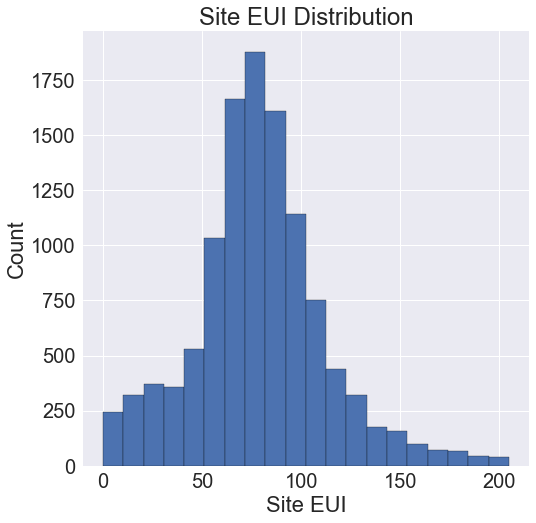

In [15]:
# Histogram Plot of Site EUI
figsize(8, 8)
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); plt.title('Site EUI Distribution');

After removing the outliers, we can get back to the analysis.

This plot looks a little less suspicious and is close to normally distributed with a long tail on the right side (it has a positive skew). 

## Looking for Relationships

In order to look at the effect of categorical variables on the score, we can make a [density plot](https://datavizcatalogue.com/methods/density_plot.html) colored by the value of the categorical variable. 

The first plot we will make shows the distribution of scores by the property type. In order to not clutter the plot, we will limit the graph to building types that have more than 100 observations in the dataset. 

In [16]:
# Create a list of buildings with more than 100 measurements
types = data.dropna(subset=['score'])
types = types['Largest Property Use Type'].value_counts()
types = list(types[types.values > 100].index)

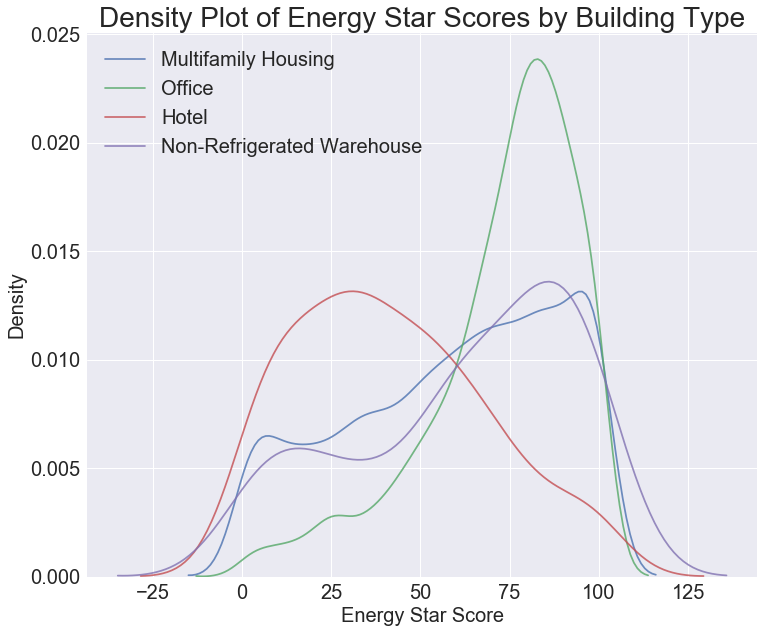

In [17]:
# Plot of distribution of scores for building categories
figsize(12, 10)

# Plot each building
for b_type in types:
    # Select the building type
    subset = data[data['Largest Property Use Type'] == b_type]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Building Type', size = 28);

To examine another categorical variable, borough, we can make the same graph, but this time colored by the borough.

In [18]:
# Create a list of boroughs with more than 100 observations
boroughs = data.dropna(subset=['score'])
boroughs = boroughs['Borough'].value_counts()
boroughs = list(boroughs[boroughs.values > 100].index)

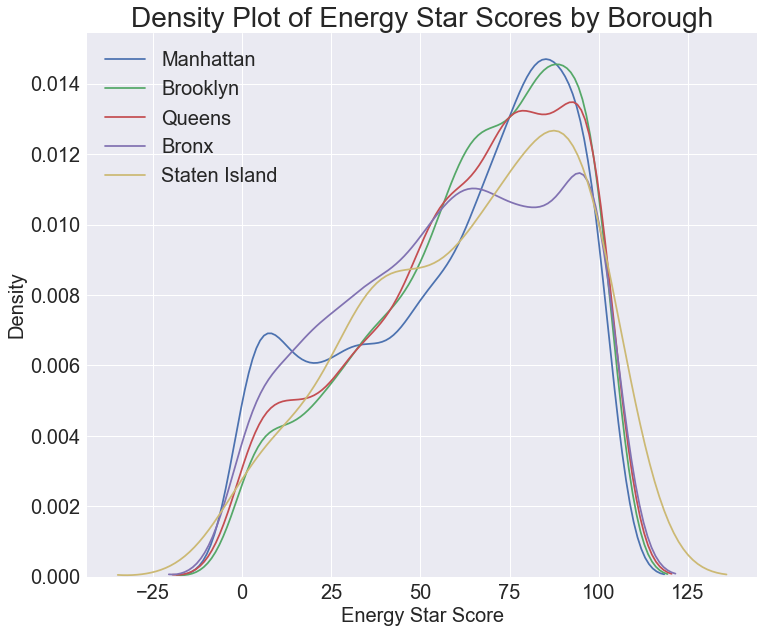

In [19]:
# Plot of distribution of scores for boroughs
figsize(12, 10)

# Plot each borough distribution of scores
for borough in boroughs:
    # Select the building type
    subset = data[data['Borough'] == borough]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = borough);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Borough', size = 28);

The borough of the building does not seem to make as significant a difference in the distribution of the score as does the building type. Nonetheless, it might make sense to include the borough as a categorical variable. 

## Correlations between Features and Target

In order to quantify correlations between the features (variables) and the target, we can calculate the [Pearson correlation coefficient](http://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/).

In [20]:
# Find all correlations and sort 
correlations_data = data.corr()['score'].sort_values()

# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(15))

Site EUI (kBtu/ft²)                                          -0.723864
Weather Normalized Site EUI (kBtu/ft²)                       -0.713993
Weather Normalized Source EUI (kBtu/ft²)                     -0.645542
Source EUI (kBtu/ft²)                                        -0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346046
Direct GHG Emissions (Metric Tons CO2e)                      -0.147792
Weather Normalized Site Natural Gas Use (therms)             -0.135211
Natural Gas Use (kBtu)                                       -0.133648
Year Built                                                   -0.121249
Total GHG Emissions (Metric Tons CO2e)                       -0.113136
Electricity Use - Grid Purchase (kBtu)                       -0.050639
Weather Normalized Site Electricity (kWh)                    -0.048207
Latitude                                                     -0.048196
Proper

There are several strong negative correlations between the features and the target. The most negative correlations with the score are the different categories of Energy Use Intensity (EUI), `Site EUI (kBtu/ft²)` and  `Weather Normalized Site EUI (kBtu/ft²)` (these vary slightly in how they are calculated). The EUI is the amount of energy used by a building divided by the square footage of the buildings and is meant to be a measure of the efficiency of a building with a lower score being better. Intuitively, these correlations then make sense: as the EUI increases, the Energy Star Score tends to decrease. 

To account for possible non-linear relationships, we can take square root and natural log transformations of the features and then calculate the correlation coefficients with the score. To try and capture any possible relationships between the borough or building type (remember these are categorical variables) and the score we will have to one-hot encode these columns.

In the following code, we take log and square root transformations of the numerical variables, one-hot encode the two selected categorical variables (building type and borough), calculate the correlations between all of the features and the score, and display the top 15 most positive and top 15 most negative correlations. This is a lot, but with pandas, it is straightforward to do each step!

In [21]:
# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop buildings without an energy star score
features = features.dropna(subset = ['score'])

# Find correlations with the score 
correlations = features.corr()['score'].dropna().sort_values()

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [22]:
# Display most negative correlations
correlations.head(15)

Site EUI (kBtu/ft²)                                            -0.723864
Weather Normalized Site EUI (kBtu/ft²)                         -0.713993
sqrt_Site EUI (kBtu/ft²)                                       -0.699817
sqrt_Weather Normalized Site EUI (kBtu/ft²)                    -0.689019
sqrt_Weather Normalized Source EUI (kBtu/ft²)                  -0.671044
sqrt_Source EUI (kBtu/ft²)                                     -0.669396
Weather Normalized Source EUI (kBtu/ft²)                       -0.645542
Source EUI (kBtu/ft²)                                          -0.641037
log_Source EUI (kBtu/ft²)                                      -0.622892
log_Weather Normalized Source EUI (kBtu/ft²)                   -0.620329
log_Site EUI (kBtu/ft²)                                        -0.612039
log_Weather Normalized Site EUI (kBtu/ft²)                     -0.601332
log_Weather Normalized Site Electricity Intensity (kWh/ft²)    -0.424246
sqrt_Weather Normalized Site Electricity Intensity 

In [23]:
# Display most positive correlations
correlations.tail(15)

sqrt_Order                                                         0.028662
Borough_Queens                                                     0.029545
Largest Property Use Type_Supermarket/Grocery Store                0.030038
Largest Property Use Type_Residence Hall/Dormitory                 0.035407
Order                                                              0.036827
Largest Property Use Type_Hospital (General Medical & Surgical)    0.048410
Borough_Brooklyn                                                   0.050486
log_Community Board                                                0.055495
Community Board                                                    0.056612
sqrt_Community Board                                               0.058029
sqrt_Council District                                              0.060623
log_Council District                                               0.061101
Council District                                                   0.061639
Largest Prop

After transforming the features, the strongest relationships are still those related to Energy Use Intensity (EUI). The log and square root transformations do not seem the have resulted in any stronger relationships. There are no strong positive linear relationships although we do see that a building type of office (`Largest Property Use Type_Office`) is slightly positively correlated with the score. This variable is a one-hot encoded representation of the categorical variables for building type.

We can use these correlations in order to perform feature selection (coming up in a little bit). Right now, let's graph the most significant correlation (in terms of absolute value) in the dataset which is `Site EUI (kBtu/ft^2)`. We can color the graph by the building type to show how that affects the relationship. 

## Two-Variable Plots

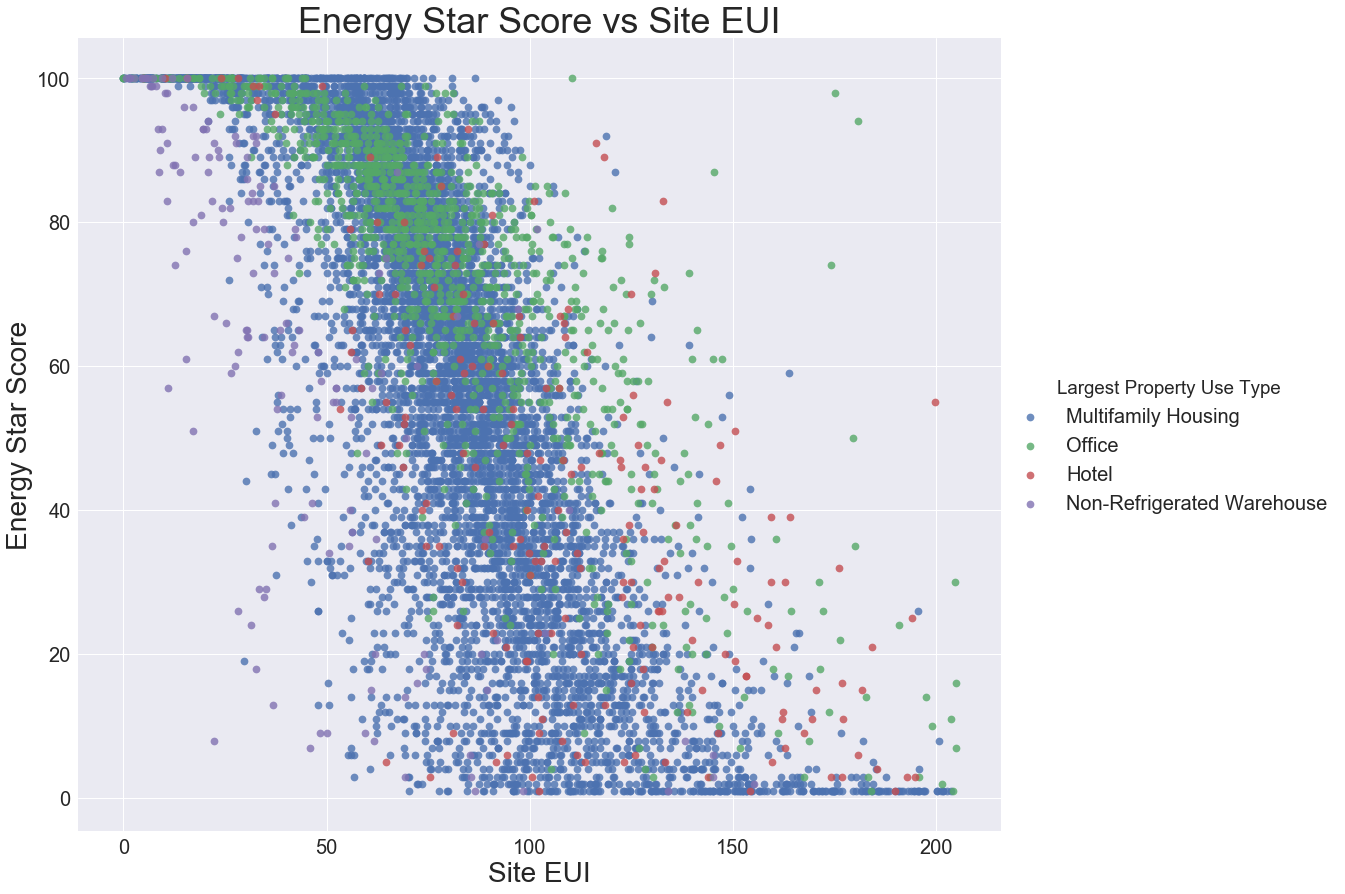

In [24]:
figsize(12, 10)

# Extract the building types
features['Largest Property Use Type'] = data.dropna(subset = ['score'])['Largest Property Use Type']

# Limit to building types with more than 100 observations (from previous code)
features = features[features['Largest Property Use Type'].isin(types)]

# Use seaborn to plot a scatterplot of Score vs Log Source EUI
sns.lmplot('Site EUI (kBtu/ft²)', 'score', 
          hue = 'Largest Property Use Type', data = features,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          size = 12, aspect = 1.2);

# Plot labeling
plt.xlabel("Site EUI", size = 28)
plt.ylabel('Energy Star Score', size = 28)
plt.title('Energy Star Score vs Site EUI', size = 36);

There is a clear negative relationship between the Site EUI and the score. The relationship is not perfectly linear (it looks with a correlation coefficient of -0.7, but it does look like this feature will be important for predicting the score of a building. 

### Pairs Plot

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


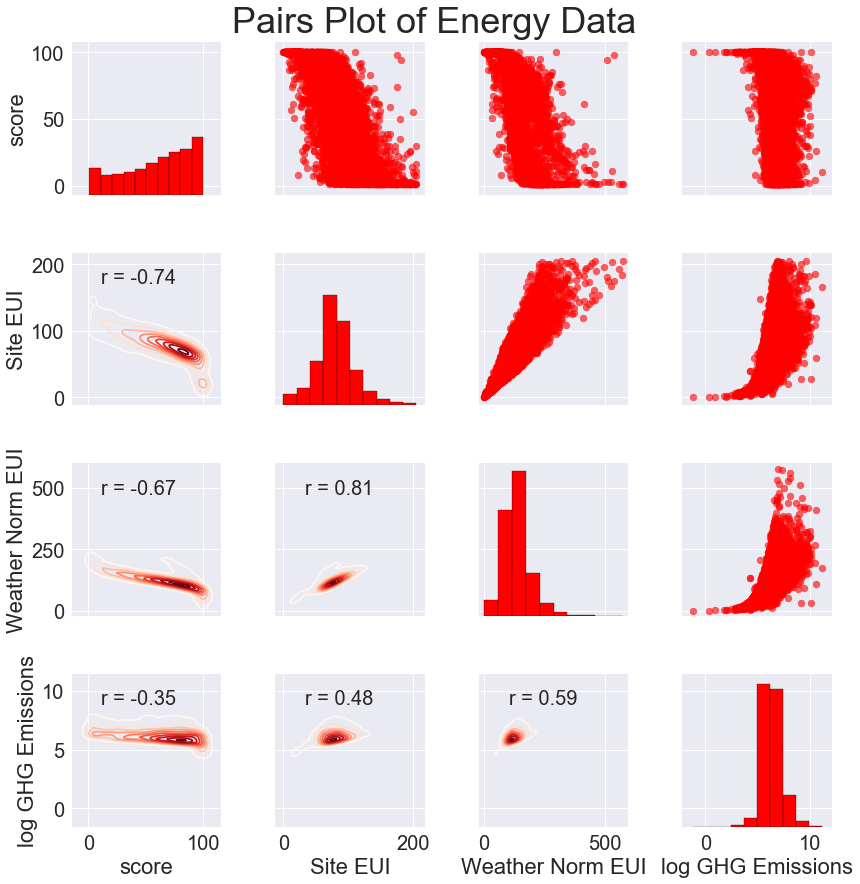

In [25]:
# Extract the columns to  plot
plot_data = features[['score', 'Site EUI (kBtu/ft²)', 
                      'Weather Normalized Source EUI (kBtu/ft²)', 
                      'log_Total GHG Emissions (Metric Tons CO2e)']]

# Replace the inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Rename columns 
plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI', 
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
                                        'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'})

# Drop na values
plot_data = plot_data.dropna()

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of Energy Data', size = 36, y = 1.02);

# Feature Engineering and Selection

We learned the following from EDA which can help us in engineering/selecting features:

* The score distribution varies by building type and to a lesser extent by borough. Although we will focus on numerical features, we should also include these two categorical features in the model. 
* Taking the log transformation of features does not result in significant increases in the linear correlations between features and the score

In this project, we will take the following steps for feature engineering:

* Select only the numerical variables and two categorical variables (borough and property use type)
* Add in the log transformation of the numerical variables
* One-hot encode the categorical variables

For feature selection, we will do the following:

* Remove [collinear features](https://statinfer.com/204-1-9-issue-of-multicollinearity-in-python/)

We will discuss collinearity (also called [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)) when we get to that process! 

The following code selects the numeric features, adds in log transformations of all the numeric features, selects and one-hot encodes the categorical features, and joins the sets of features together. 

In [26]:
# Copy the original data
features = data.copy()

# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

features.shape

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


(11319, 110)

At this point, we have 11319 observations (buildings) with 109 different features (one column is the score). Not all of these features are likely to be important for predicting the score, and several of these features are also redundant because they are highly correlated. We will deal with this second issue below. 

## Remove Collinear Features

Highly [collinear features](http://psychologicalstatistics.blogspot.com/2013/11/multicollinearity-and-collinearity-in.html) have a significant correlation coefficent between them. For example, in our dataset, the `Site EUI` and `Weather Norm EUI` are highly correlated because they are just slightly different means of calculating the energy use intensity. 

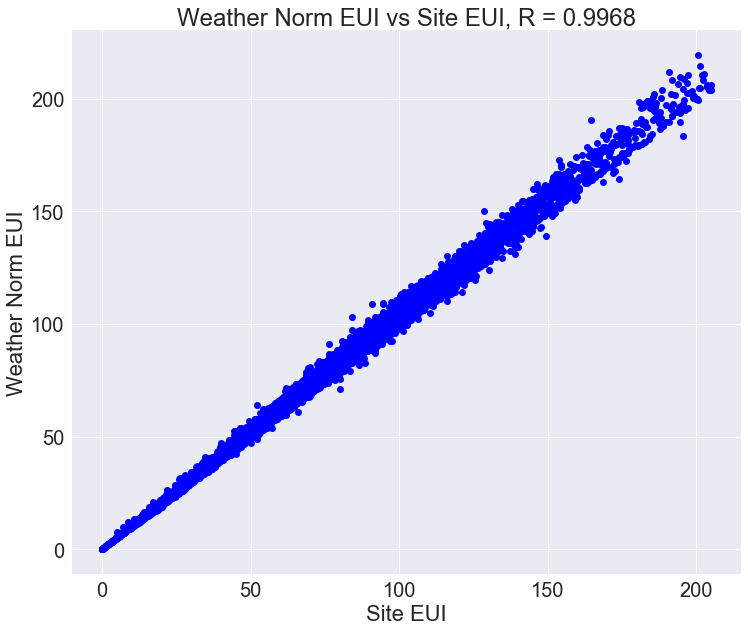

In [27]:
plot_data = data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna()

plt.plot(plot_data['Site EUI (kBtu/ft²)'], plot_data['Weather Normalized Site EUI (kBtu/ft²)'], 'bo')
plt.xlabel('Site EUI'); plt.ylabel('Weather Norm EUI')
plt.title('Weather Norm EUI vs Site EUI, R = %0.4f' % np.corrcoef(data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna(), rowvar=False)[0][1]);

While variables in a dataset are usually correlated to a small degree, highly collinear variables can be redundant in the sense that we only need to retain one of the features to give our model the necessary information.

Removing collinear features is a method to reduce model complexity by decreasing the number of features and can help to increase model generalization.  It can also help us to interpret the model because we only have to worry about a single variable, such as EUI, rather than how both EUI and weather normalized EUI affect the score. 

There are a number of methods for removing collinear features, such as using the [Variance Inflation Factor](http://www.statisticshowto.com/variance-inflation-factor/). We will use a simpler metric, and remove features that have a correlation coefficient above a certain threshold with each other (not with the score because we want variables that are highly correlated with the score!) For a more thorough discussion of removing collinear variables, check out [this notebook on Kaggle](https://www.kaggle.com/robertoruiz/dealing-with-multicollinearity/code).

The following code removes the collinear features based on a threshold we select for the correlation coefficients by removing one of the two features that are compared. It also prints the correlations that it removes so we can see the effect of adjusting the threshold. We will use a threshold of 0.6 which removes one of a pair of features if the correlation coefficient between the features exceeds this value. 

In [28]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Energy Star Score
    y = x['score']
    x = x.drop(columns = ['score'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)', 
                          'Water Use (All Water Sources) (kgal)',
                          'log_Water Use (All Water Sources) (kgal)',
                          'Largest Property Use Type - Gross Floor Area (ft²)'])
    
    # Add the score back in to the data
    x['score'] = y
               
    return x

In [29]:
# Remove the collinear features above a specified correlation coefficient
features = remove_collinear_features(features, 0.6);

In [30]:
# Remove any columns with all na values
features  = features.dropna(axis=1, how = 'all')
features.shape

(11319, 65)

Our final dataset now has 64 features (one of the columns is the target).

#### Additional Feature Selection

There are plenty of more methods for [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html). Some popular methods include [principal components analysis (PCA)](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) which transforms the features into a reduced number of dimensions that preserve the greatest variance, or [independent components analysis (ICA)](http://cs229.stanford.edu/notes/cs229-notes11.pdf) which aims to find the independent sources in a set of features. However, while these methods are effective at reducing the number of features, they create new features that have no physical meaning and hence make interpreting a model nearly impossible. 

These methods are very helpful for dealing with high-dimensional data and I would suggest [reading more on the topic](https://machinelearningmastery.com/feature-selection-machine-learning-python/) if you plan on dealing with machine learning problems! 

## Split Into Training and Testing Sets

For our problem, we will first extract all the buildings without an Energy Star Score (we don't know the true answer for these buildings so they will not be helpful for training or testing). Then, we will split the buildings with an Energy Star Score into a testing set of 30% of the buildings, and a training set of 70% of the buildings. 

In [31]:
# Extract the buildings with no score and the buildings with a score
no_score = features[features['score'].isna()]
score = features[features['score'].notnull()]

print(no_score.shape)
print(score.shape)

(1858, 65)
(9461, 65)


In [32]:
# Separate out the features and targets
features = score.drop(columns='score')
targets = pd.DataFrame(score['score'])

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(6622, 64)
(2839, 64)
(6622, 1)
(2839, 1)


We have 1858 buildings with no score, 6622 buildings with a score in the training set, and 2839 buildings with a score in the testing set. We have one final step to take in this notebook: determining a naive baseline for our models to beat! 

# Establish a Baseline 

It's important to establish a naive baseline before we beginning making machine learning models. If the models we build cannot outperform a naive guess then we might have to admit that machine learning is not suited for this problem. This could be because we are not using the right models, because we need more data, or because there is a simpler solution that does not require machine learning. Establishing a baseline is crucial so we do not end up building a machine learning model only to realize we can't actually solve the problem.

For a regression task, a good naive baseline is to predict the median value of the target on the training set for all examples on the test set. This is simple to implement and sets a relatively low bar for our models: if they cannot do better than guessing the median value, then we will need to rethink our approach. 

## Metric: Mean Absolute Error

There are a number of metrics used in machine learning tasks and it can be [difficult to know which one to choose](https://www.analyticsvidhya.com/blog/2016/02/7-important-model-evaluation-error-metrics/). Most of the time it will depend on the particular problem and if you have a specific goal to optimize for. I like [Andrew Ng's advice to use a single real-value performance metric](https://www.coursera.org/learn/machine-learning-projects/lecture/wIKkC/single-number-evaluation-metric) in order to compare models because it simplifies the evaluate process. Rather than calculating multiple metrics and trying to determine how important each one is, we should use a single number. In this case, because we doing regression, the [__mean absolute error__](https://people.duke.edu/~rnau/compare.htm) is an appropriate metric. This is also interpretable because it represents the average amount our estimate if off by in the same units as the target value. 

The function below calculates the mean absolute error between true values and predictions.

In [33]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

Now we can make the median guess and evaluate it on the test set.

In [34]:
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 66.00
Baseline Performance on the test set: MAE = 24.5164


This shows our average estimate on the test set is off by about 25 points. The scores are between 1 and 100 so this means the average error from a naive method if about 25%. The naive method of guessing the median training value provides us a low baseline for our models to beat! 

In [35]:
# Save the no scores, training, and testing data
no_score.to_csv('data/no_score.csv', index = False)
X.to_csv('data/training_features.csv', index = False)
X_test.to_csv('data/testing_features.csv', index = False)
y.to_csv('data/training_labels.csv', index = False)
y_test.to_csv('data/testing_labels.csv', index = False)